In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/retail-transaction-dataset/products.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

1. надо добавить красивых графиков

# Data loading, EDA & Data Preporasion

In [3]:
df = pd.read_csv('/kaggle/input/retail-transaction-dataset/products.csv')

In [4]:
df.head()

,TransactionID,CustomerID,Products,Timestamp
0,1,C546,"Dish Sponge, Flatbread with Meat, Chips, Orang...",2025-02-18
1,2,C385,"Onion, Juice, Flatbread with Meat, Chicken",2025-04-26
2,3,C292,"Egg, Flatbread with Meat, Banana, Pizza",2025-04-25
3,4,C863,"Ice Cream, Soda, Orange, Potato, Cereal, Choco...",2025-01-14
4,5,C171,"Ice Cream, Soap, Shampoo, Chicken, Banana, Bea...",2025-04-20


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TransactionID  30000 non-null  int64 
 1   CustomerID     30000 non-null  object
 2   Products       30000 non-null  object
 3   Timestamp      30000 non-null  object
dtypes: int64(1), object(3)
memory usage: 937.6+ KB


In [6]:
df.duplicated().sum()

0

In [7]:
for c in ['TransactionID', 'CustomerID', 'Products', 'Timestamp']:
    print(df[c].nunique())

30000
1000
29889
120


* 30,000 unique transactions: no duplicates
* 1,000 customers: an average of ~30 purchases per customer
* 29,889 unique shopping carts: almost all different, high variability
* 120 unique dates: the period covers approximately 4 months in 2025

In [8]:
df.groupby('CustomerID')['TransactionID'].count().describe()

count    1000.000000
mean       30.000000
std         5.714775
min        14.000000
25%        26.000000
50%        30.000000
75%        33.000000
max        52.000000
Name: TransactionID, dtype: float64

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


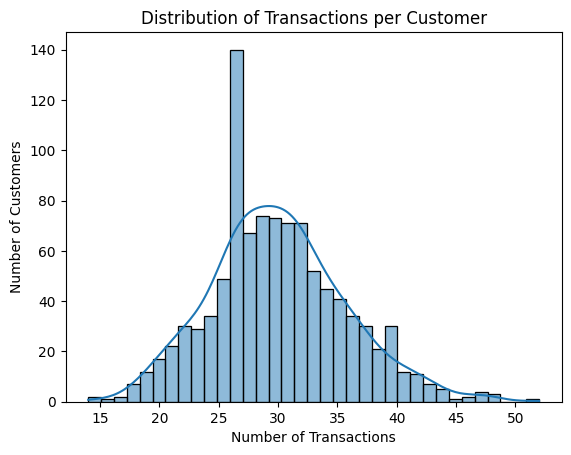

In [9]:
sns.histplot(df.groupby('CustomerID')['TransactionID'].count(), kde=True, bins=35, edgecolor='black')
plt.title('Distribution of Transactions per Customer')
plt.xlabel('Number of Transactions')
plt.ylabel('Number of Customers')
plt.show()

In [10]:
df.groupby('CustomerID')['TransactionID'].count()

CustomerID
C1       34
C10      31
C100     30
C1000    31
C101     42
         ..
C995     25
C996     15
C997     26
C998     28
C999     43
Name: TransactionID, Length: 1000, dtype: int64

In [11]:
order_counts = df.groupby('CustomerID')['TransactionID'].count()
order_counts.value_counts().sort_index()

TransactionID
14     1
15     1
16     1
17     2
18     7
19    12
20    17
21    22
22    30
23    29
24    34
25    49
26    61
27    79
28    67
29    74
30    73
31    71
32    71
33    52
34    45
35    41
36    34
37    30
38    21
39    16
40    14
41    12
42    11
43     7
44     5
45     1
46     2
47     4
48     3
52     1
Name: count, dtype: int64

The sample includes 1,000 customers.
On average, each customer completed approximately 30 transactions.
The number of transactions by customer ranges from 14 to 52, indicating some, but not significant, heterogeneity in purchasing activity.

Most customers complete between 26 and 33 transactions (interquartile range).
The standard deviation is 5.7, confirming a moderate level of variation.

It can be concluded that the distribution of transaction numbers by customer is fairly uniform, with no significant outliers or highly active customers significantly different from the general population.

In [12]:
print(df['Timestamp'].min())
print(df['Timestamp'].max())

2025-01-01
2025-04-30


The data covers the period from January 1, 2025 to April 30, 2025, i.e. 4 months.

In [13]:
df['Products'].apply(lambda x: len(x.split(','))).describe()

count    30000.000000
mean         6.583633
std          2.332464
min          3.000000
25%          5.000000
50%          7.000000
75%          9.000000
max         11.000000
Name: Products, dtype: float64

On average, shoppers purchase approximately 6–7 items per transaction.
The number of items in a shopping cart ranges from 3 to 11, indicating relatively compact purchases.

Most orders include 5 to 9 items (interquartile range), and the standard deviation of 2.33 indicates moderate variation in cart size.

In [14]:
duplicated = df.Products[df['Products'].duplicated()]

In [15]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(duplicated)

856                         Fish, Juice, Lentil
3496                   Milk, Juice, Dish Sponge
3888                    Lentil, Pizza, Cucumber
5330                     Pizza, Fish, Chickpeas
6743                  Sausage, Honey, Ice Cream
6804                         Cereal, Honey, Egg
7663                        Lentil, Fish, Honey
7965               Pizza, Cucumber, Honey, Soda
8628                  Chickpeas, Bread, Cracker
9441                 Beans, Soap, Water, Lentil
9515           Soda, Dish Sponge, Potato, Water
10225         Pizza, Flatbread with Meat, Onion
10354        Tomato, Pizza, Flatbread with Meat
10432        Chickpeas, Dish Sponge, Strawberry
10831                     Tomato, Cereal, Pizza
10866                       Onion, Cracker, Egg
10884                       Onion, Cola, Tomato
11002                    Sausage, Chips, Yogurt
11043                      Pizza, Butter, Chips
11202                    Fish, Chicken, Sausage
11559                  Soda, Minced Meat

In [16]:
df['Product_list'] = df['Products'].apply(lambda x: [p.strip() for p in x.split(',')])

In [17]:
df.head()

,TransactionID,CustomerID,Products,Timestamp,Product_list
0,1,C546,"Dish Sponge, Flatbread with Meat, Chips, Orang...",2025-02-18,"[Dish Sponge, Flatbread with Meat, Chips, Oran..."
1,2,C385,"Onion, Juice, Flatbread with Meat, Chicken",2025-04-26,"[Onion, Juice, Flatbread with Meat, Chicken]"
2,3,C292,"Egg, Flatbread with Meat, Banana, Pizza",2025-04-25,"[Egg, Flatbread with Meat, Banana, Pizza]"
3,4,C863,"Ice Cream, Soda, Orange, Potato, Cereal, Choco...",2025-01-14,"[Ice Cream, Soda, Orange, Potato, Cereal, Choc..."
4,5,C171,"Ice Cream, Soap, Shampoo, Chicken, Banana, Bea...",2025-04-20,"[Ice Cream, Soap, Shampoo, Chicken, Banana, Be..."


In [18]:
unique_products = set(chain.from_iterable(df['Product_list']))

In [19]:
len(unique_products)

40

In [20]:
unique_products

{'Apple',
 'Banana',
 'Beans',
 'Bread',
 'Butter',
 'Cereal',
 'Cheese',
 'Chicken',
 'Chickpeas',
 'Chips',
 'Chocolate',
 'Cola',
 'Cookie',
 'Cracker',
 'Cucumber',
 'Detergent',
 'Dish Sponge',
 'Dumpling',
 'Egg',
 'Fish',
 'Flatbread with Meat',
 'Honey',
 'Ice Cream',
 'Juice',
 'Lentil',
 'Milk',
 'Minced Meat',
 'Onion',
 'Orange',
 'Pizza',
 'Potato',
 'Rice',
 'Sausage',
 'Shampoo',
 'Soap',
 'Soda',
 'Strawberry',
 'Tomato',
 'Water',
 'Yogurt'}

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


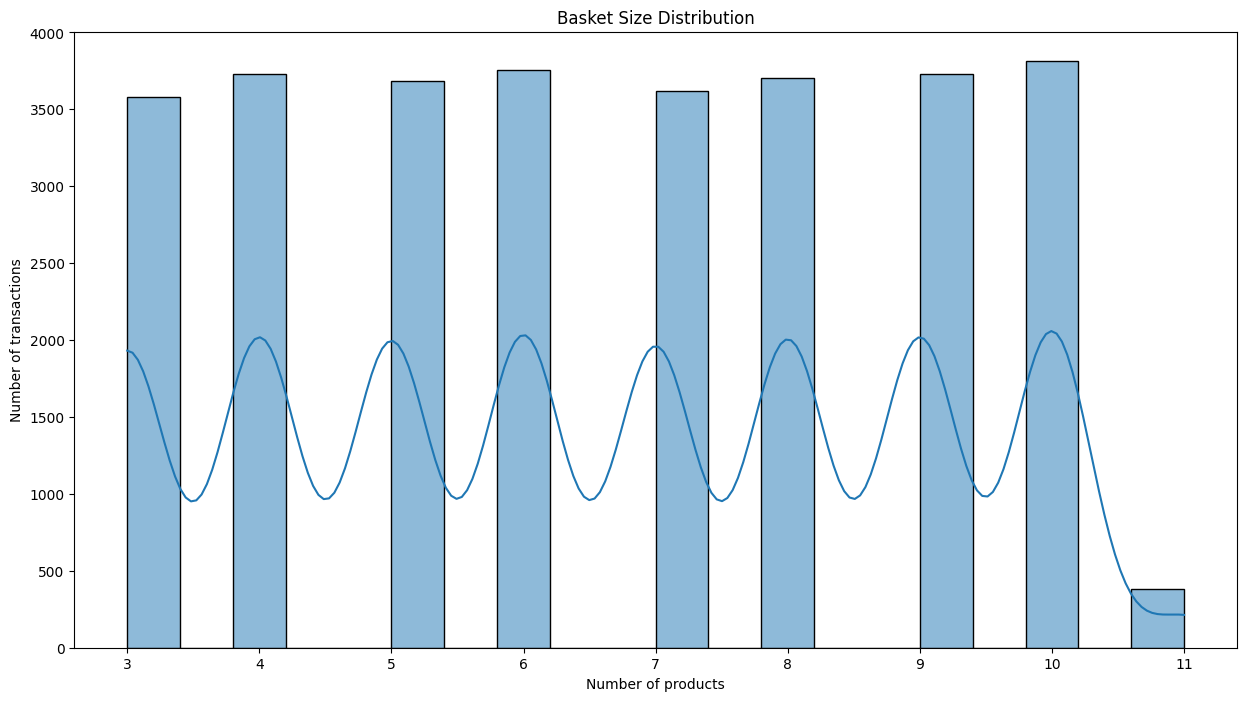

In [21]:
plt.figure(figsize=(15, 8))
sns.histplot(df['Products'].apply(lambda x: len(x.split(','))), bins=20, kde=True)
plt.title('Basket Size Distribution')
plt.xlabel('Number of products')
plt.ylabel('Number of transactions')
plt.show()

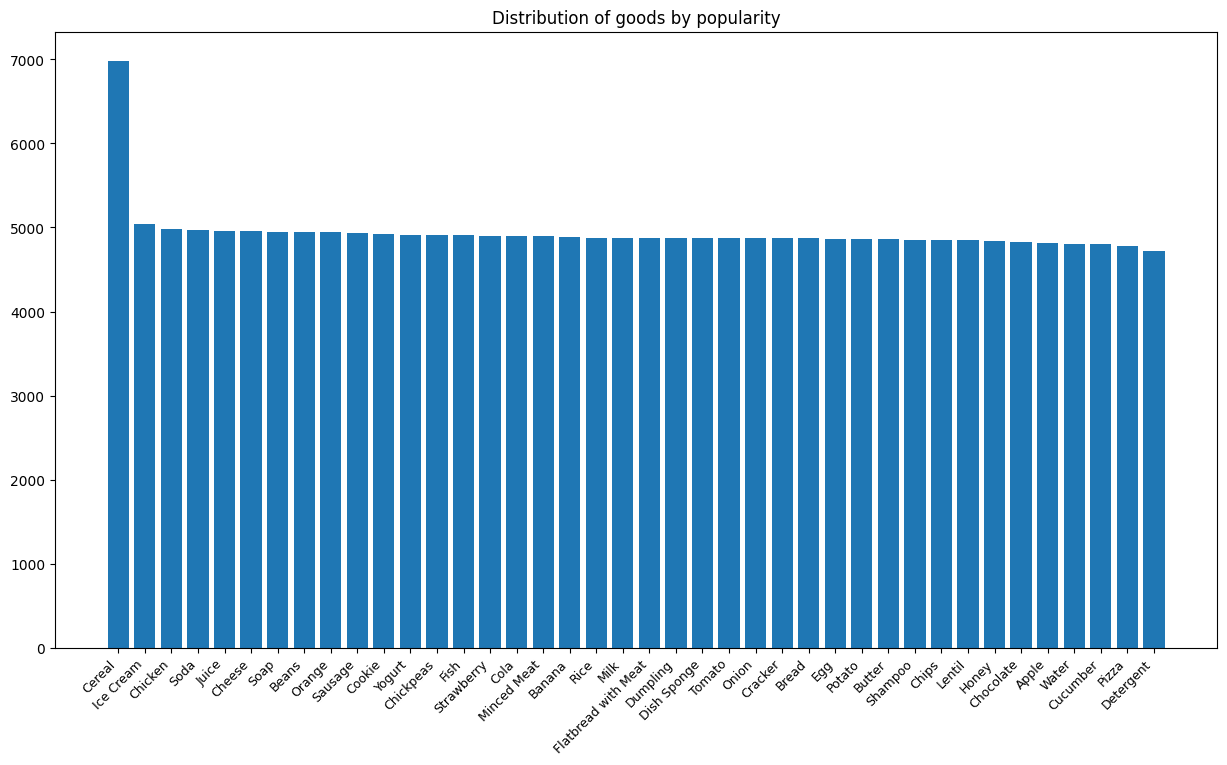

In [22]:
from collections import Counter

all_products = list(chain.from_iterable(df['Product_list']))
product_counts = Counter(all_products)
top_products = product_counts.most_common(40)

plt.figure(figsize=(15, 8))
plt.bar([p[0] for p in top_products], [p[1] for p in top_products])
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.title('Distribution of goods by popularity')
plt.show()

Conclusion:

* The most popular product is Cereal, with significantly more purchases than all others (approximately 7,000 transactions).

* Ice Cream is second in popularity, but by a significant margin (approximately 5,000).

* The remaining products are found with approximately equal frequency, with approximately 4,800–5,000 purchases each.

* This suggests that the product range is generally used evenly, with no clear leaders, except for one: Cereal.

* It can be assumed that Cereal is a key product, most often included in carts (perhaps as a "bait" or staple good).

# Dataset prep

In [23]:
transactions = df['Product_list'].tolist()

In [24]:
te = TransactionEncoder()

In [25]:
te_ary = te.fit(transactions).transform(transactions)

In [26]:
basket_df = pd.DataFrame(te_ary, columns=te.columns_)

In [27]:
basket_df.head()

,Apple,Banana,Beans,Bread,Butter,Cereal,Cheese,Chicken,Chickpeas,Chips,...,Potato,Rice,Sausage,Shampoo,Soap,Soda,Strawberry,Tomato,Water,Yogurt
0,False,False,False,False,True,False,False,False,False,True,...,False,True,True,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,True,False,False,False,False,...,True,False,False,False,False,True,False,False,False,False
4,False,True,True,False,False,False,True,True,False,False,...,False,False,False,True,True,False,False,False,False,False


In [28]:
basket_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Apple                30000 non-null  bool 
 1   Banana               30000 non-null  bool 
 2   Beans                30000 non-null  bool 
 3   Bread                30000 non-null  bool 
 4   Butter               30000 non-null  bool 
 5   Cereal               30000 non-null  bool 
 6   Cheese               30000 non-null  bool 
 7   Chicken              30000 non-null  bool 
 8   Chickpeas            30000 non-null  bool 
 9   Chips                30000 non-null  bool 
 10  Chocolate            30000 non-null  bool 
 11  Cola                 30000 non-null  bool 
 12  Cookie               30000 non-null  bool 
 13  Cracker              30000 non-null  bool 
 14  Cucumber             30000 non-null  bool 
 15  Detergent            30000 non-null  bool 
 16  Dish Sponge          3

# Association Rules

In [29]:
freq_items = apriori(basket_df, min_support=0.005, use_colnames=True, verbose=1)

Processing 42864 combinations | Sampling itemset size 4


In [30]:
freq_items

,support,itemsets
0,0.160467,(Apple)
1,0.163033,(Banana)
2,0.164967,(Beans)
3,0.162333,(Bread)
4,0.162033,(Butter)
...,...,...
1731,0.005167,"(Pizza, Sausage, Water)"
1732,0.005067,"(Soda, Shampoo, Potato)"
1733,0.005067,"(Shampoo, Rice, Soap)"
1734,0.005167,"(Sausage, Strawberry, Water)"


In [31]:
rules = association_rules(freq_items, metric='lift', min_threshold = 1)

In [32]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(Apple),(Cheese),0.160467,0.165267,0.027167,0.169298,1.024392,1.0,0.000647,1.004853,0.028363,0.090990,0.004829,0.166839
1,(Cheese),(Apple),0.165267,0.160467,0.027167,0.164381,1.024392,1.0,0.000647,1.004684,0.028526,0.090990,0.004662,0.166839
2,(Apple),(Chicken),0.160467,0.166033,0.027067,0.168675,1.015909,1.0,0.000424,1.003177,0.018653,0.090393,0.003167,0.165847
3,(Chicken),(Apple),0.166033,0.160467,0.027067,0.163019,1.015909,1.0,0.000424,1.003050,0.018777,0.090393,0.003041,0.165847
4,(Apple),(Chickpeas),0.160467,0.163700,0.028200,0.175737,1.073533,1.0,0.001932,1.014604,0.081589,0.095281,0.014394,0.174002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3657,"(Soap, Water)",(Yogurt),0.027367,0.163767,0.005033,0.183922,1.123074,1.0,0.000552,1.024698,0.112670,0.027046,0.024103,0.107328
3658,"(Yogurt, Water)",(Soap),0.027100,0.165067,0.005033,0.185732,1.125193,1.0,0.000560,1.025379,0.114363,0.026897,0.024751,0.108112
3659,(Soap),"(Yogurt, Water)",0.165067,0.027100,0.005033,0.030493,1.125193,1.0,0.000560,1.003499,0.133260,0.026897,0.003487,0.108112
3660,(Yogurt),"(Soap, Water)",0.163767,0.027367,0.005033,0.030735,1.123074,1.0,0.000552,1.003475,0.131048,0.027046,0.003463,0.107328


In [33]:
rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head(20)

,antecedents,consequents,support,confidence,lift
1977,(Milk),"(Cereal, Cookie)",0.016800,0.103279,2.701273
1972,"(Cereal, Cookie)",(Milk),0.016800,0.439407,2.701273
936,"(Banana, Cereal)",(Milk),0.016100,0.430865,2.648762
941,(Milk),"(Banana, Cereal)",0.016100,0.098975,2.648762
2669,(Milk),"(Shampoo, Cereal)",0.016033,0.098566,2.635443
2664,"(Shampoo, Cereal)",(Milk),0.016033,0.428699,2.635443
2684,"(Cereal, Tomato)",(Milk),0.016367,0.427328,2.627017
2689,(Milk),"(Cereal, Tomato)",0.016367,0.100615,2.627017
2310,"(Egg, Cereal)",(Milk),0.015800,0.426259,2.620445
2315,(Milk),"(Egg, Cereal)",0.015800,0.097131,2.620445


 **Key Findings:**

1. **The strongest associations are with milk (Milk)**  it appears in almost all top rules either as a purchased item or as a related item.
 This suggests that milk is the central product in the basket, around which frequent combinations are built.

2. **Strongest Rules:**

* (Cookie, Cereal) → (Milk) with lift = 2.70
 If people buy cereal and cookies, the likelihood of buying milk is almost 2.7 times higher than chance.
* Similarly, (Banana, Cereal) - (Milk) and (Shampoo, Cereal) - (Milk) show similar patterns.

3. Cereal (cereal) appears in almost all combinations, especially with Milk, Bread, Tomato, Orange, Egg, and others.
 Cereal can be considered the product around which most shopping carts are formed – an “anchor product.”

4. Pairs with high confidence (around 0.60) indicate that when certain products are present, the likelihood of purchasing another exceeds 60%.
For example:

* (Milk, Bread) - (Cereal) – 60.5%
* (Milk, Tomato) - (Cereal) – 60.4%
 This means that adding “Cereal” recommendations to such combinations would be very logical.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if

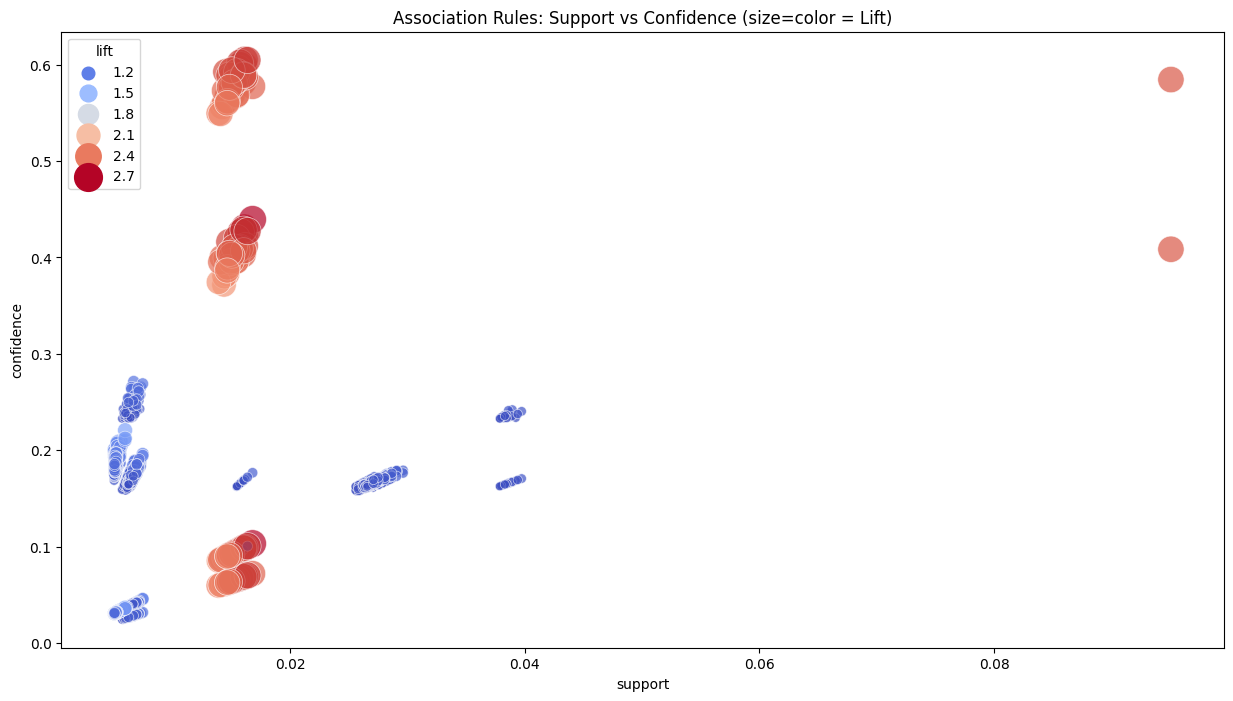

In [34]:
plt.figure(figsize=(15,8))
sns.scatterplot(
    data=rules, x='support', y='confidence',
    size='lift', hue='lift', palette='coolwarm', alpha=0.7, sizes=(40, 400)
)
plt.title('Association Rules: Support vs Confidence (size=color = Lift)')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


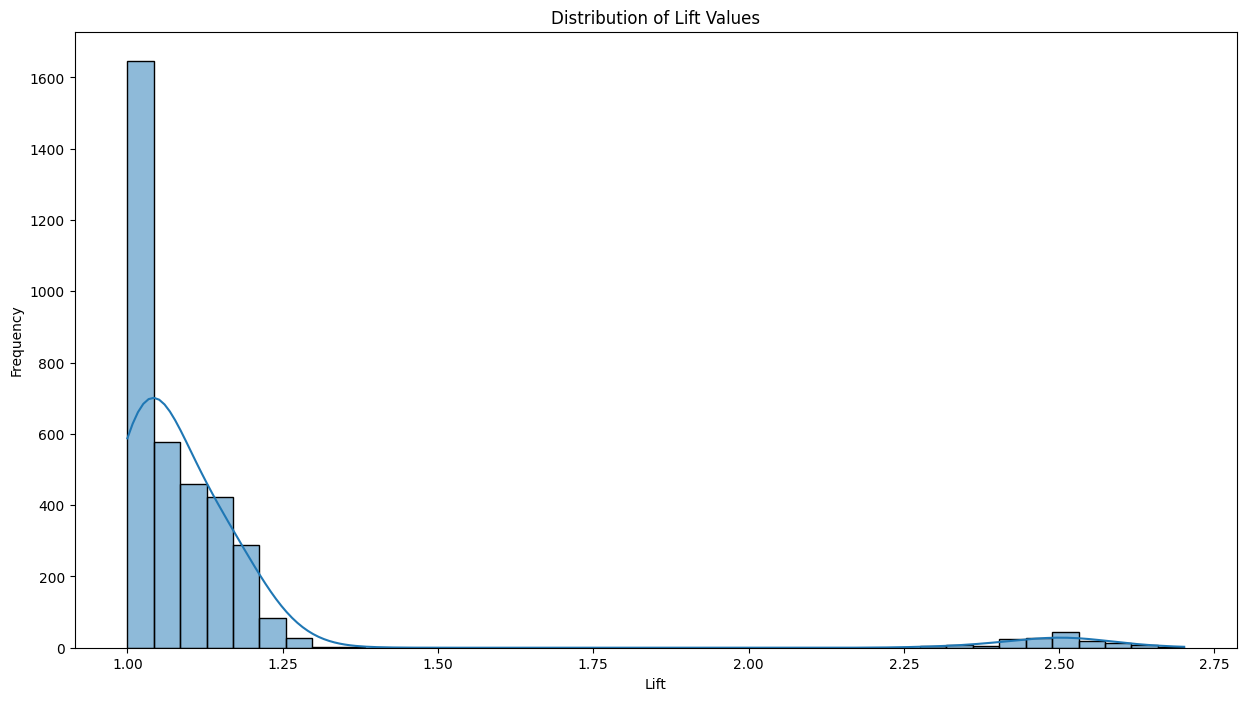

In [35]:
plt.figure(figsize=(15,8))
sns.histplot(rules['lift'], bins=40, kde=True)
plt.title('Distribution of Lift Values')
plt.xlabel('Lift')
plt.ylabel('Frequency')
plt.show()

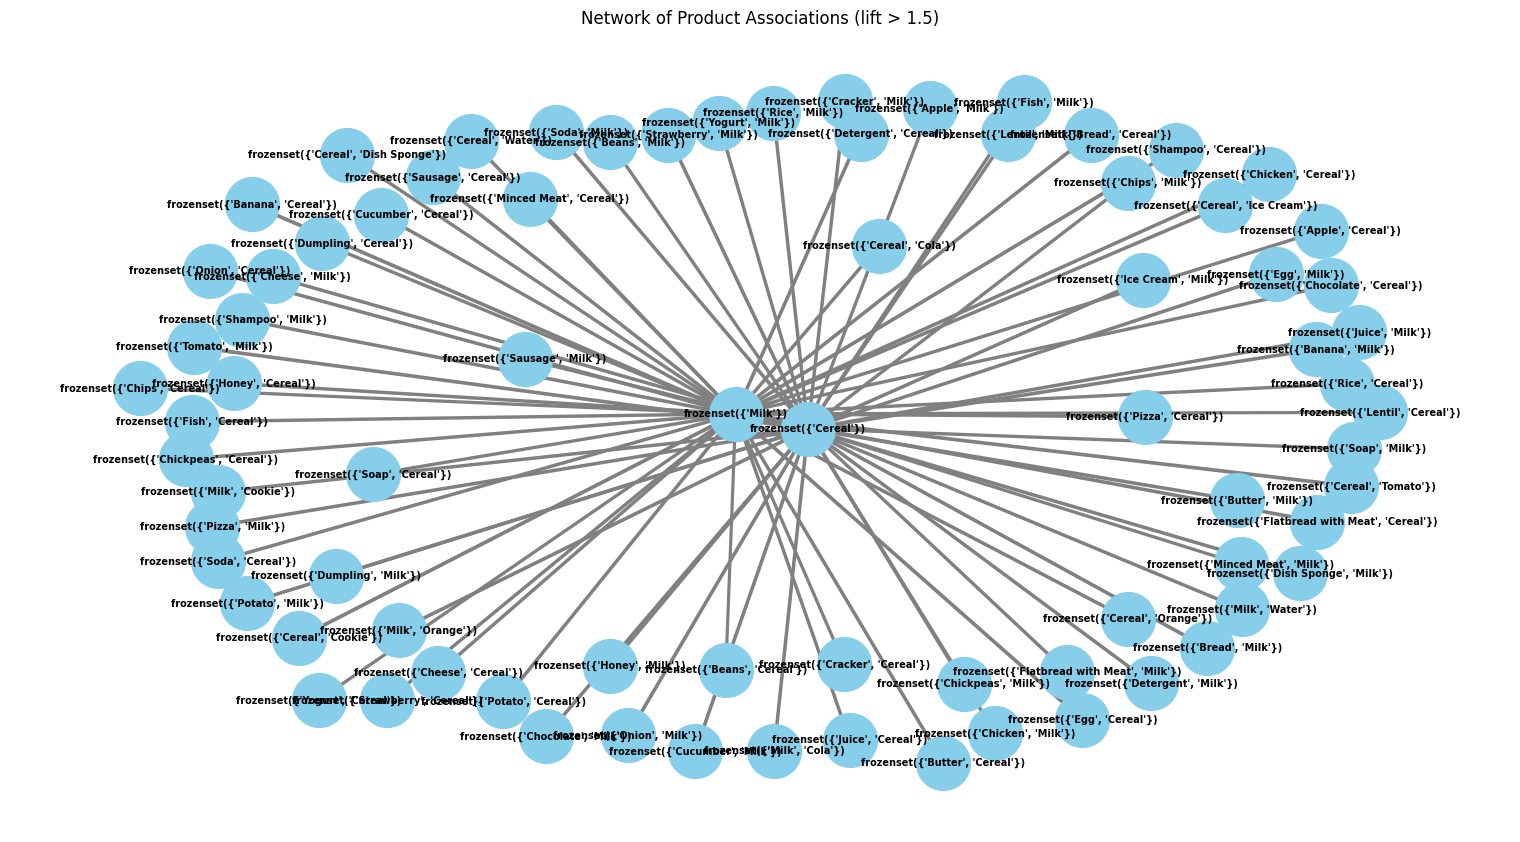

In [36]:
import networkx as nx

G = nx.from_pandas_edgelist(
    rules[rules['lift'] > 1.5],
    source='antecedents', target='consequents',
    edge_attr='lift'
)

plt.figure(figsize=(15, 8))
pos = nx.spring_layout(G, k=0.5, iterations=20)
nx.draw(
    G, pos,
    with_labels=True,
    node_color='skyblue',
    node_size=1500,
    font_size=7,
    font_weight='bold',
    edge_color='gray',
    width=[d['lift'] for (_,_,d) in G.edges(data=True)]
)
plt.title('Network of Product Associations (lift > 1.5)')
plt.show()


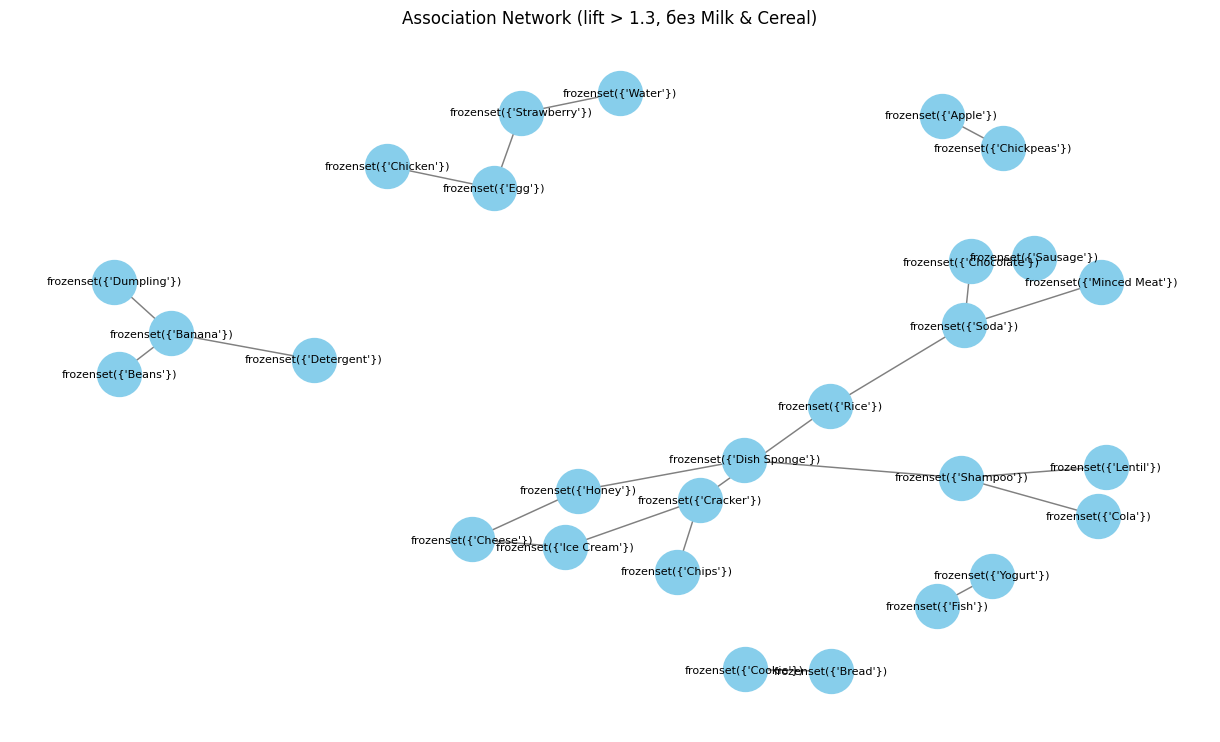

In [37]:
# фильтруем, чтобы убрать молоко и хлопья
popular = ['Milk', 'Cereal']
r = rules[
    (rules['lift'] > 1.05) &  # чуть мягче
    (rules['support'] > 0.01) &  # чтобы убрать случайные
    ~rules['antecedents'].apply(lambda x: any(i in popular for i in x)) &
    ~rules['consequents'].apply(lambda x: any(i in popular for i in x))
]

# строим граф
G = nx.from_pandas_edgelist(r, 'antecedents', 'consequents', edge_attr='lift')
pos = nx.spring_layout(G, k=0.4, seed=42)

# рисуем
plt.figure(figsize=(12, 7))
nx.draw(G, pos,
        with_labels=True,
        node_color='skyblue',
        node_size=1000,
        font_size=8,
        edge_color='gray',
        width=[d['lift'] for _,_,d in G.edges(data=True)])
plt.title('Association Network (lift > 1.3, без Milk & Cereal)')
plt.show()

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


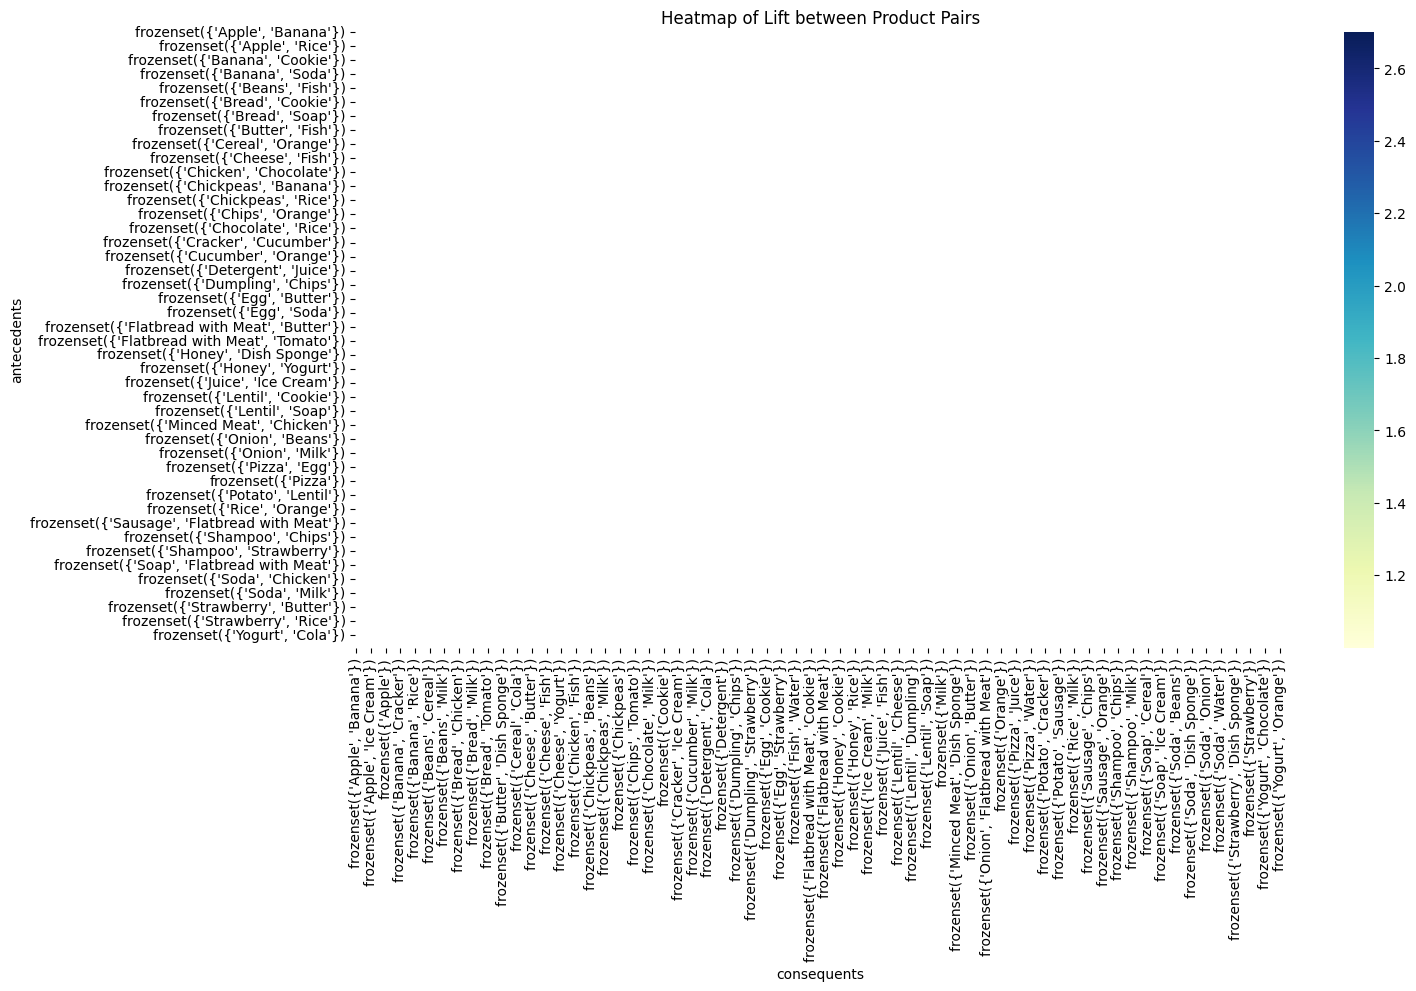

In [38]:
pivot = rules.pivot_table(
    values='lift',
    index=rules['antecedents'].astype(str),
    columns=rules['consequents'].astype(str)
)
plt.figure(figsize=(15,8))
sns.heatmap(pivot, cmap='YlGnBu', linewidths=0.1)
plt.title('Heatmap of Lift between Product Pairs')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


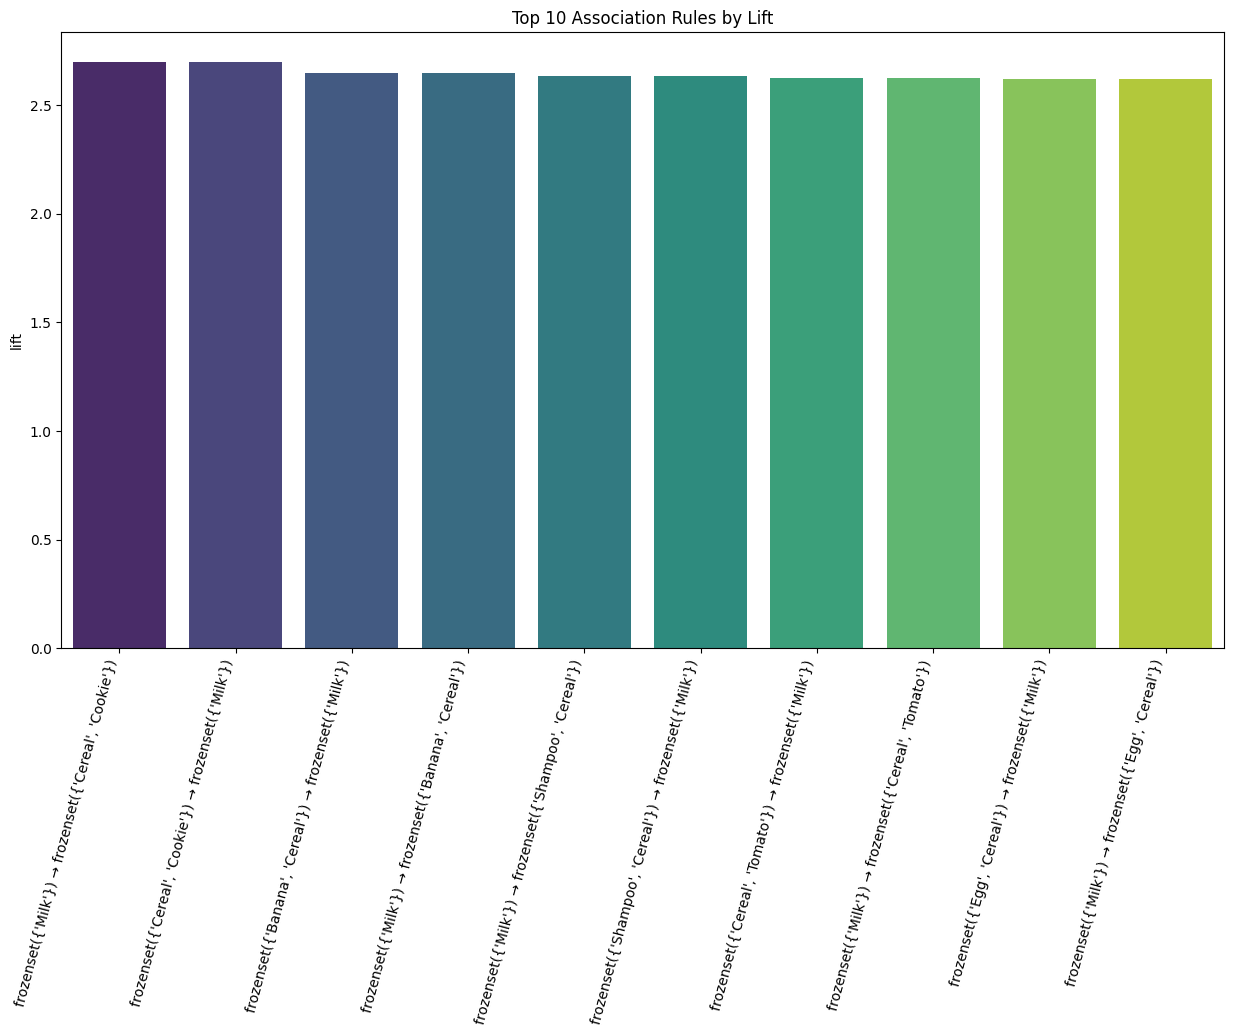

In [39]:
top_rules = rules.sort_values('lift', ascending=False).head(10)
plt.figure(figsize=(15,8))
sns.barplot(data=top_rules, y='lift',
            x=top_rules['antecedents'].astype(str) + ' → ' + top_rules['consequents'].astype(str),
            palette='viridis')
plt.xticks(rotation=75, ha='right')
plt.title('Top 10 Association Rules by Lift')
plt.show()

# Recommender Engine

In [40]:
unique_products

{'Apple',
 'Banana',
 'Beans',
 'Bread',
 'Butter',
 'Cereal',
 'Cheese',
 'Chicken',
 'Chickpeas',
 'Chips',
 'Chocolate',
 'Cola',
 'Cookie',
 'Cracker',
 'Cucumber',
 'Detergent',
 'Dish Sponge',
 'Dumpling',
 'Egg',
 'Fish',
 'Flatbread with Meat',
 'Honey',
 'Ice Cream',
 'Juice',
 'Lentil',
 'Milk',
 'Minced Meat',
 'Onion',
 'Orange',
 'Pizza',
 'Potato',
 'Rice',
 'Sausage',
 'Shampoo',
 'Soap',
 'Soda',
 'Strawberry',
 'Tomato',
 'Water',
 'Yogurt'}

In [41]:
def recommend_products_bidirectional(purchased_items, rules, top_n=5, metric='lift'):
    """
    Рекомендации с учётом обеих сторон правил: antecedents и consequents.
    
    purchased_items: list или set купленных товаров (строки)
    rules: DataFrame из association_rules (antecedents/consequents — frozenset)
    top_n: сколько рекомендаций вернуть
    metric: 'lift' или 'confidence' (для расчёта score)
    """
    purchased = set(purchased_items)
    
    if not purchased:
        return []

    candidates_list = []

    for _, row in rules.iterrows():
        antecedents = set(row['antecedents'])
        consequents = set(row['consequents'])

        # 1) Exact match по antecedents (все antecedents куплены)
        if antecedents.issubset(purchased):
            # кандидаты — consequents, weight = 1
            for c in consequents:
                if c not in purchased:
                    candidates_list.append({
                        'product': c,
                        'score': row['lift'] * row['confidence'] * 1.0
                    })

        # 2) Exact match по consequents (все consequents куплены)
        if consequents.issubset(purchased):
            # кандидаты — antecedents, weight = 0.7 (чуть меньше, чтобы не доминировало)
            for a in antecedents:
                if a not in purchased:
                    candidates_list.append({
                        'product': a,
                        'score': row['lift'] * row['confidence'] * 0.7
                    })

        # 3) Partial match по antecedents (хотя бы один куплен, но не все)
        if antecedents & purchased and not antecedents.issubset(purchased):
            weight = 1.0 / max(1, len(antecedents))
            for c in consequents:
                if c not in purchased:
                    candidates_list.append({
                        'product': c,
                        'score': row['lift'] * row['confidence'] * weight
                    })

        # 4) Partial match по consequents (хотя бы один куплен, но не все)
        if consequents & purchased and not consequents.issubset(purchased):
            weight = 0.7 / max(1, len(consequents))  # чуть меньше вес для обратки
            for a in antecedents:
                if a not in purchased:
                    candidates_list.append({
                        'product': a,
                        'score': row['lift'] * row['confidence'] * weight
                    })

    if not candidates_list:
        return []

    candidates_df = pd.DataFrame(candidates_list)

    # Группируем по продукту, берём максимум score
    recs = candidates_df.groupby('product')['score'].max().sort_values(ascending=False)

    return recs.index.tolist()[:top_n]


Функция "recommend_products_bidirectional"   - рекомендательная система на основе правил ассоциации (association rules), которая учитывает *обе стороны правил*:

* **"antecedents"** — товары, которые обычно покупают *перед* другими.
* **"consequents"** — товары, которые обычно покупают *после* других.

Алгоритм:

1. Берем список товаров, которые уже купил пользователь (**"purchased_items"**).
2. Проходим по всем правилам ассоциаций (**"rules"**) и ищем совпадения:
* Полное совпадение с **"antecedents"** - рекомендуем **"consequents"** (веса = 1.0)
* Полное совпадение с **"consequents"** - рекомендуем **"antecedents"** (веса = 0.7, чуть меньше)
* Частичное совпадение с **"antecedents"** - рекомендуем **"consequents"** (веса = 1 / число antecedents)
* Частичное совпадение с **"consequents"** - рекомендуем **"antecedents"** (веса = 0.7 / число consequents)

3.  Каждой рекомендации присваиваем **"score" = "lift" * <confidence" * "weight"**.
4.  Объединяем одинаковые товары и берем максимальный score, чтобы избежать дублирования.
5.  Возвращаем топ-N рекомендаций.

     

The "recommend_products_bidirectional" function is a recommendation system based on association rules that considers *both sides* of the rules:

* **"antecedents"** — products that are typically purchased *before* others.
* **"consequents"** — products that are typically purchased *after* others.

Algorithm:

1. Take the list of products the user has already purchased (**"purchased_items"**).
2. We go through all the association rules (**"rules"**) and look for matches:
* A complete match with **"antecedents"** - we recommend **"consequents"** (weight = 1.0)
* A complete match with **"consequents"** - we recommend **"antecedents"** (weight = 0.7, slightly less)
* A partial match with **"antecedents"** - we recommend **"consequents"** (weight = 1 / number of antecedents)
* A partial match with **"consequents"** - we recommend **"antecedents"** (weight = 0.7 / number of consequents)

3. We assign a **"score" = "lift" * <confidence" * "weight"** to each recommendation.
4. We combine identical products and take the maximum score to avoid duplication.
5. We return the top N recommendations.

In [42]:
recommend_products_bidirectional(['Beans'], rules)

['Cereal', 'Milk', 'Banana', 'Minced Meat', 'Cucumber']

In [43]:
recommend_products_bidirectional(['Cereal', 'Milk'], rules)

['Bread', 'Tomato', 'Orange', 'Onion', 'Banana']

# Evaluation

In [44]:
all_recommendations = []

for product in unique_products: 
    recs = recommend_products_bidirectional([product], rules)
    all_recommendations.extend(recs)

unique_recs = set(all_recommendations)
coverage = len(unique_recs) / len(unique_products)

print(f"Coverage: {coverage:.2%}")
print(f"Unique recommended products: {len(unique_recs)} out {len(unique_products)}")

Coverage: 92.50%
Unique recommended products: 37 out 40


In [45]:
all_recs = []

# Берём все товары и выдаём рекомендации по каждому
for product in unique_products:
    recs = recommend_products_bidirectional([product], rules, top_n=5)
    all_recs.extend(recs)

N = len(all_recs)
if N <= 1:
    gini_simpson = 0.0
else:
    counts = Counter(all_recs)
    sum_ni_ni1 = sum(n * (n - 1) for n in counts.values())
    D = sum_ni_ni1 / (N * (N - 1))
    gini_simpson = 1 - D

print(f"Gini-Simpson Diversity Index: {gini_simpson:.2%}")

Gini-Simpson Diversity Index: 91.55%
